In [1]:
import numpy as np 
import pandas as pd
import os
import io
import glob
import re
import sys
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import animation, rc
import plotly.express as px
import plotly.graph_objects as go

import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly
import plotly.io as pio

import geopandas as gpd

import plotly
from plotly.subplots import make_subplots

pio.renderers.default = "notebook_connected"

In [2]:
files = glob.glob('dataset/*.csv')
data = []
for i in files :
    i = re.sub("dataset\\\\", "", i)
    data.append(re.sub(".csv","",i))
for i in range(len(files)) :
    globals()[data[i]] = pd.read_csv(files[i])
data

['Case',
 'Latitude',
 'Longitude',
 'PatientInfo',
 'PatientRoute',
 'Policy',
 'Region',
 'SearchTrend',
 'SeoulFloating',
 'SFedit',
 'Time',
 'TimeAge',
 'TimeGender',
 'TimeProvince',
 'Weather']

In [3]:
twtinfo = PatientInfo[PatientInfo.age == '20s']
twtinfo.head()

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state
3,1000000004,7.0,male,1991.0,20s,Korea,Seoul,Mapo-gu,NaN,overseas inflow,1.0,NaN,9.0,2020-01-26,2020-01-30,2020-02-15,NaN,released
4,1000000005,9.0,female,1992.0,20s,Korea,Seoul,Seongbuk-gu,NaN,contact with patient,2.0,1.000000e+09,2.0,NaN,2020-01-31,2020-02-24,NaN,released
6,1000000007,11.0,male,1995.0,20s,Korea,Seoul,Jongno-gu,NaN,contact with patient,3.0,1.000000e+09,0.0,NaN,2020-01-31,2020-02-10,NaN,released
7,1000000008,13.0,male,1992.0,20s,Korea,Seoul,etc,NaN,overseas inflow,1.0,NaN,0.0,NaN,2020-02-02,2020-02-24,NaN,released
11,1000000012,24.0,male,1992.0,20s,Korea,Seoul,etc,NaN,overseas inflow,1.0,NaN,0.0,NaN,2020-02-07,2020-02-27,NaN,released


20s data!!!

In [4]:
twt_GyungBook = twtinfo[twtinfo.province == 'Gyeongsangbuk-do']
twt_GyungBook.head()

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state
1975,6001000001,67.0,female,1991.0,20s,Korea,Gyeongsangbuk-do,Gyeongsan-si,NaN,Shincheonji Church,NaN,1.200000e+09,7.0,NaN,2020-02-19,2020-04-09,NaN,released
1979,6001000005,106.0,female,1991.0,20s,Korea,Gyeongsangbuk-do,Gyeongsan-si,NaN,NaN,NaN,NaN,2.0,NaN,2020-02-20,2020-03-18,NaN,released
1984,6001000010,237.0,female,2000.0,20s,Korea,Gyeongsangbuk-do,Gyeongsan-si,NaN,NaN,NaN,NaN,3.0,NaN,2020-02-21,2020-03-26,NaN,released
1993,6001000019,615.0,female,1997.0,20s,Korea,Gyeongsangbuk-do,Gyeongsan-si,NaN,NaN,NaN,NaN,9.0,NaN,2020-02-23,2020-03-17,NaN,released
1995,6001000021,626.0,male,1997.0,20s,Korea,Gyeongsangbuk-do,Gyeongsan-si,NaN,NaN,NaN,NaN,2.0,NaN,2020-02-23,2020-03-25,NaN,released


20s 경북 only!!

## City

In [6]:
total = gpd.read_file("total")
total.head(3)
gb = total[total.CTP_ENG_NM == "Gyeongsangbuk-do"]

C:\Users\JYW\Anaconda3\lib\site-packages\matplotlib\colors.py:527: RuntimeWarning:

invalid value encountered in less



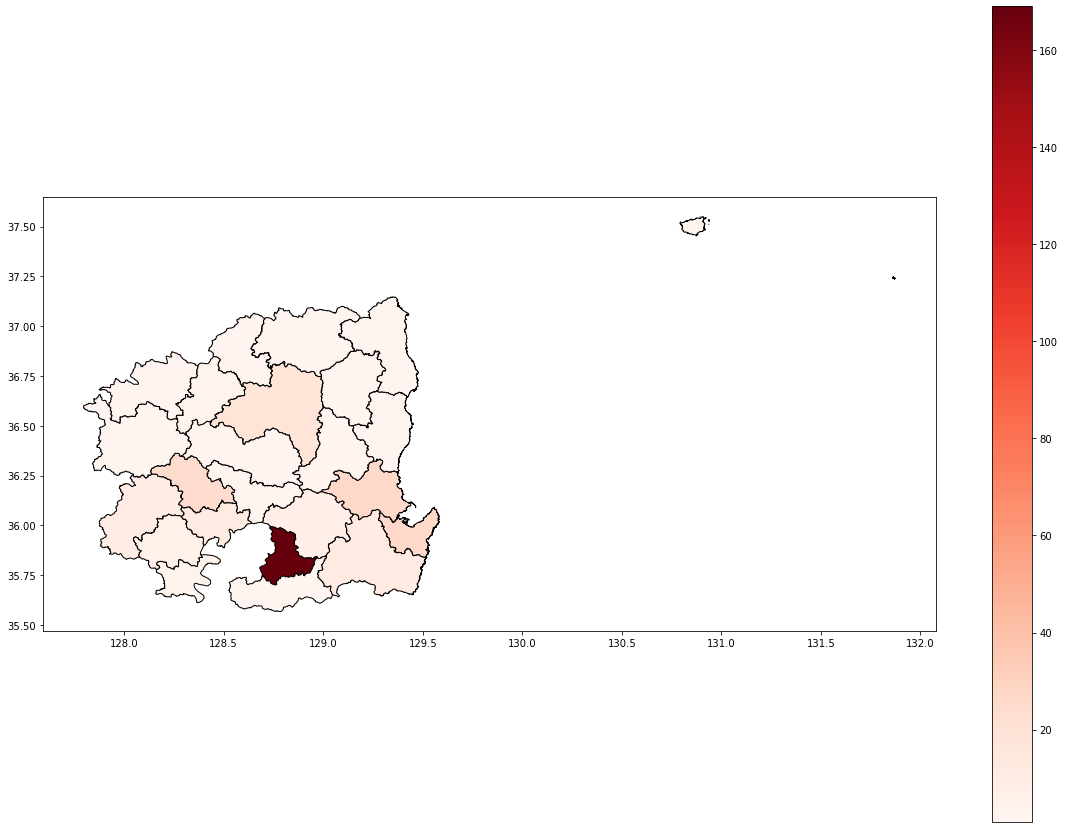

In [7]:
twt_city = pd.DataFrame(twt_GyungBook.groupby('city').count().patient_id)
twt_city["SIG_ENG_NM"] = list(twt_city.index) 

merge_gb = pd.merge(gb, twt_city, how='left', on=['SIG_ENG_NM'])
merge_gb.plot(column='patient_id',legend=True, cmap="Reds",edgecolor="black",figsize=(20,15))


경산시가 압도적으로 높음 -> 경산시는 대구랑 가까움 -> 즉, 경북이 높은 것이 아니라 대구랑 가까웠던 경산시가 높았던 거였음\
그럼 이 들은 왜 높은걸까? 신천진가?

## Infection Case 

In [8]:
twt_GyungBook.infection_case.value_counts()

etc                         60
contact with patient        19
Shincheonji Church           8
overseas inflow              6
Milal Shelter                3
Cheongdo Daenam Hospital     1
Name: infection_case, dtype: int64

.... 접촉자 아니면 etc구만..

## Time plot

In [9]:
twt_time = pd.DataFrame(twtinfo.groupby('confirmed_date').count().patient_id)
twt_time["date"] = list(twt_time.index) 
twt_GyungBook_time = pd.DataFrame(twt_GyungBook.groupby('confirmed_date').count().patient_id)
twt_GyungBook_time["date"] = list(twt_GyungBook_time.index) 

fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(
    go.Scatter(x=twt_time.date , y=twt_GyungBook.patient_id, name="All 20s"),
    secondary_y=False,
)
fig.add_trace(
    go.Scatter(x=twt_GyungBook_time.date, y=twt_GyungBook_time.patient_id, name="GyeongBuk 20s"),
    secondary_y=True,
)
# Add figure title
fig.update_layout(
    title_text="Confirmed"
)
# Set x-axis title
fig.update_xaxes(title_text="Date")
# Set y-axes
fig.update_layout(
    yaxis=dict(
        title="All",
    ),
    yaxis2=dict(
        title="GyeongBuk",
    )
)
fig.show() 

2월말~3월초까지 경북이 휩쓸고 지나간 뒤에도 20대는 꾸준히 늘어난다.\
왜일까 ㅠㅠ